# Diffusion Mnist

## Autoencoder and Latent Creation

### Install

In [1]:
# Install required libraries
!pip install torch torchvision einops matplotlib tqdm torchsummary torchviz


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from torch import nn
from einops import rearrange
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
from torchsummary import summary
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torchviz import make_dot


### Classes and Functions

In [4]:
def get_transforms():
    return transforms.Compose([
        transforms.ToTensor(),
    ])

def get_mnist_dataloader(train=True):
    dataset = datasets.MNIST(
        root="./data", train=train, download=True, transform=get_transforms()
    )
    dataloader = DataLoader(dataset, batch_size=Config.BATCH_SIZE, shuffle=train)
    return dataloader

In [5]:
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16, bias=False):
        super(CALayer, self).__init__()
        # global average pooling: feature --> point
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # feature channel downscale and upscale --> channel weight
        self.conv_du = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=bias),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=bias),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y


class CAB(nn.Module):
    def __init__(self, n_feat, reduction=16, bias=False):
        super(CAB, self).__init__()
        self.body = nn.Sequential(
            nn.Conv2d(n_feat, n_feat, 3, padding=1, bias=bias),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_feat, n_feat, 3, padding=1, bias=bias),
        )
        self.ca = CALayer(n_feat, reduction, bias=bias)

    def forward(self, x):
        res = self.body(x)
        res = self.ca(res)
        return res + x  # Residual Connection



In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, channels, num_cabs_per_layer):
        super().__init__()
        layers = []
        for in_ch, out_ch, num_cabs in zip(channels[:-1], channels[1:], num_cabs_per_layer):
            layers.append(nn.Conv2d(in_ch, out_ch, 3, stride=2, padding=1))
            layers.extend([CAB(out_ch, reduction=Config.REDUCTION_FACTOR) for _ in range(num_cabs)])  # Add CABs
            layers.append(nn.ReLU())
        self.conv_layers = nn.Sequential(*layers)
        self.flatten = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels[-1] * 7 * 7, latent_dim),
        )

    def forward(self, x):
        if Config.DEBUG:
            print(f"Encoder Input Shape: {x.shape}")
        x = self.conv_layers(x)
        if Config.DEBUG:
            print(f"Encoder After Conv Layers: {x.shape}")
        x = self.flatten(x)
        if Config.DEBUG:
            print(f"Encoder Output (Flattened): {x.shape}")
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim, channels, num_cabs_per_layer):
        super().__init__()
        self.channels = channels  # Save channels as a class attribute

        # Define the linear layer for latent-to-feature map transformation
        self.linear = nn.Linear(latent_dim, channels[0] * 7 * 7)


        layers = []
        for in_ch, out_ch, num_cabs in zip(channels[:-1], channels[1:], num_cabs_per_layer):
            layers.append(nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1))  # Deconvolution layer
            layers.extend([CAB(out_ch, reduction=Config.REDUCTION_FACTOR) for _ in range(num_cabs)])  # Add CABs
            if out_ch != 1:  # Activation: ReLU for intermediate layers, Sigmoid for the final layer
                layers.append(nn.ReLU())
            else:
                layers.append(nn.Sigmoid())

        self.deconv_layers = nn.Sequential(*layers)

    def forward(self, z):
        if Config.DEBUG:
            print(f"Decoder Input Shape: {z.shape}")

        # Latent to feature map
        x = self.linear(z)
        if Config.DEBUG:
            print(f"After Linear Layer: {x.shape} (Expected: [batch_size, {self.channels[0] * 7 * 7}])")

        x = rearrange(x, "b (c h w) -> b c h w", c=self.channels[0], h=7, w=7)
        if Config.DEBUG:
            print(f"After Reshape: {x.shape} (Expected: [batch_size, {self.channels[0]}, 7, 7])")

        # Pass through the deconvolution layers
        x = self.deconv_layers(x)
        if Config.DEBUG:
            print(f"Decoder Output Shape: {x.shape} (Expected: [batch_size, 1, 28, 28])")

        return x


In [7]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = Encoder(latent_dim, Config.ENCODER_CHANNELS, Config.NUM_CABS_ENCODER)
        self.decoder = Decoder(latent_dim, Config.DECODER_CHANNELS, Config.NUM_CABS_DECODER)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        if Config.DEBUG:
            print(f"Autoencoder Input Shape: {x.shape}")
        z = self.encoder(x)
        if Config.DEBUG:
            print(f"Latent Representation Shape: {z.shape}")
        out = self.decoder(z)
        if Config.DEBUG:
            print(f"Autoencoder Output Shape: {out.shape}")
        return out


### Training

In [8]:
def train_autoencoder():
    # Load data
    train_loader = get_mnist_dataloader(train=True)

    # Initialize model, loss, and optimizer
    autoencoder = Autoencoder(latent_dim=Config.LATENT_DIM).to(Config.DEVICE)
    summary(autoencoder, input_size=(1, Config.IMAGE_SIZE, Config.IMAGE_SIZE))

    # Visualize the model architecture
    dummy_input = torch.randn(1, 1, Config.IMAGE_SIZE, Config.IMAGE_SIZE).to(Config.DEVICE)
    dummy_output = autoencoder(dummy_input)
    dot = make_dot(dummy_output, params=dict(autoencoder.named_parameters()))
    dot.render(os.path.join(Config.SAVE_DIR, "autoencoder_architecture"), format="png")
    print(f"Model architecture visualization saved to {Config.SAVE_DIR}/autoencoder_architecture.png")

    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=Config.LR)

    loss_history = []
    # Training loop
    autoencoder.train()
    for epoch in range(Config.EPOCHS):
        epoch_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{Config.EPOCHS}")
        for images, _ in pbar:
            images = images.to(Config.DEVICE)
            # Forward pass
            recon_images = autoencoder(images)
            loss = criterion(recon_images, images)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss
            epoch_loss += loss.item()
            pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

        average_loss = epoch_loss / len(train_loader)
        loss_history.append(average_loss)
        print(f"Epoch {epoch + 1}: Average Loss: {average_loss:.4f}")

    # Save the trained model
    save_path = os.path.join(Config.SAVE_DIR, Config.MODEL_NAME)
    torch.save(autoencoder.state_dict(), save_path)
    print(f"Autoencoder training completed and model saved at: {save_path}")

    # Plot the loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, Config.EPOCHS + 1), loss_history, marker='o', label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
def train_model(model, dataloader):
    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LR)
    for epoch in range(Config.EPOCHS):
        for images, _ in dataloader:
            images = images.to(Config.DEVICE)
            loss = model.training_step(images)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch + 1}/{Config.EPOCHS}, Loss: {loss.item()}")


In [10]:
class Config:
    DATASET_NAME = "MNIST"
    IMAGE_SIZE = 28
    LATENT_DIM = 64
    SAVE_DIR = "/content/drive/My Drive/AI/Projects/diffusion mnist/models"
    MODEL_NAME = "Autoencoder_with_CAB.pth"
    BATCH_SIZE = 64
    EPOCHS = 10
    LR = 1e-4
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Encoder/Decoder Configurations
    ENCODER_CHANNELS = [1, 16, 32]         # Input -> Intermediate -> Latent
    DECODER_CHANNELS = [32, 16, 1]         # Latent -> Intermediate -> Output
    NUM_CABS_ENCODER = [1, 0]              # Number of CABs in each encoder layer
    NUM_CABS_DECODER = [1, 0]              # Number of CABs in each decoder layer
    REDUCTION_FACTOR = 8                  # Channel attention reduction factor
    DEBUG = False                          # Enable debugging prints

In [11]:
os.makedirs(Config.SAVE_DIR, exist_ok=True)

In [ ]:
#######

In [ ]:
######## careful #######

In [ ]:
#######

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 502kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.53MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
            Conv2d-2           [-1, 16, 14, 14]           2,304
              ReLU-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           2,304
 AdaptiveAvgPool2d-5             [-1, 16, 1, 1]               0
            Conv2d-6              [-1, 2, 1, 1]              32
              ReLU-7              [-1, 2, 1, 1]               0
            Conv2d-8             [-1, 16, 1, 1]              32
           Sigmoid-9             [-1, 16, 1, 1]               0
          CALayer-10           [-1, 16, 14, 14]               0
              CAB-11           [-1, 16, 14, 14]               0
             ReLU-12           [-1, 16, 14, 14]               0
           Conv2d-13        

Epoch 1/10: 100%|██████████| 938/938 [00:16<00:00, 56.07it/s, Loss=0.0325]


Epoch 1: Average Loss: 0.0633


Epoch 2/10: 100%|██████████| 938/938 [00:16<00:00, 57.94it/s, Loss=0.0146]


Epoch 2: Average Loss: 0.0199


Epoch 3/10: 100%|██████████| 938/938 [00:17<00:00, 54.92it/s, Loss=0.0125]


Epoch 3: Average Loss: 0.0141


Epoch 4/10: 100%|██████████| 938/938 [00:16<00:00, 57.75it/s, Loss=0.0091]


Epoch 4: Average Loss: 0.0108


Epoch 5/10: 100%|██████████| 938/938 [00:16<00:00, 57.62it/s, Loss=0.0073]


Epoch 5: Average Loss: 0.0085


Epoch 6/10: 100%|██████████| 938/938 [00:15<00:00, 58.67it/s, Loss=0.0067]


Epoch 6: Average Loss: 0.0067


Epoch 7/10: 100%|██████████| 938/938 [00:15<00:00, 59.19it/s, Loss=0.0060]


Epoch 7: Average Loss: 0.0058


Epoch 8/10: 100%|██████████| 938/938 [00:15<00:00, 59.12it/s, Loss=0.0046]


Epoch 8: Average Loss: 0.0052


Epoch 9/10: 100%|██████████| 938/938 [00:15<00:00, 59.47it/s, Loss=0.0044]


Epoch 9: Average Loss: 0.0048


Epoch 10/10: 100%|██████████| 938/938 [00:15<00:00, 59.02it/s, Loss=0.0053]


Epoch 10: Average Loss: 0.0045
Autoencoder training completed and model saved at: /content/drive/My Drive/AI/Projects/diffusion mnist/models/Autoencoder_with_CAB.pth


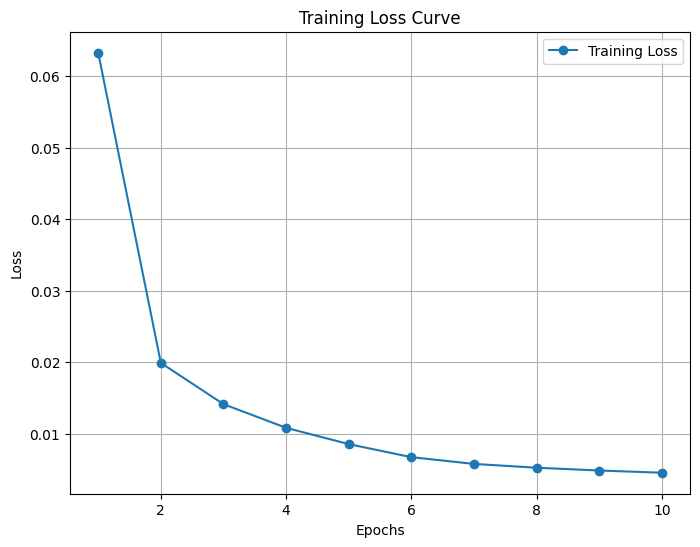

In [ ]:
train_autoencoder()


### Test and Visulizations

In [12]:
def calculate_metrics(original, reconstructed):
    original = original.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()
    ssim_scores = []
    psnr_scores = []

    for i in range(original.shape[0]):
        original_img = original[i, 0]
        reconstructed_img = reconstructed[i, 0]

        ssim_score = ssim(original_img, reconstructed_img, data_range=original_img.max() - original_img.min())
        psnr_score = psnr(original_img, reconstructed_img, data_range=original_img.max() - original_img.min())

        ssim_scores.append(ssim_score)
        psnr_scores.append(psnr_score)

    return np.mean(ssim_scores), np.mean(psnr_scores)

In [13]:
def visualize_reconstructions():
    # Load the model
    autoencoder = Autoencoder(latent_dim=Config.LATENT_DIM).to(Config.DEVICE)
    load_path = os.path.join(Config.SAVE_DIR, Config.MODEL_NAME)
    autoencoder.load_state_dict(torch.load(load_path, map_location=Config.DEVICE))
    autoencoder.eval()

    # Get test data
    test_loader = get_mnist_dataloader(train=False)
    images, _ = next(iter(test_loader))
    images = images.to(Config.DEVICE)

    # Reconstruct
    with torch.no_grad():
        recon_images = autoencoder(images)

    # Calculate metrics
    avg_ssim, avg_psnr = calculate_metrics(images, recon_images)
    print(f"Average SSIM: {avg_ssim:.4f}, Average PSNR: {avg_psnr:.2f}")

    # Visualization
    num_images = 10
    fig, axes = plt.subplots(2, num_images, figsize=(18, 6))
    fig.suptitle(f"SSIM: {avg_ssim:.4f}, PSNR: {avg_psnr:.2f}", fontsize=16, y=0.92)

    for i in range(num_images):
        original_img = images[i][0].cpu().numpy()
        reconstructed_img = recon_images[i][0].cpu().numpy()

        # Original images
        axes[0, i].imshow(original_img, cmap="gray")
        ssim_score = ssim(original_img, reconstructed_img, data_range=1.0)
        axes[0, i].set_title(f"Original", fontsize=10)
        axes[0, i].axis("off")

        # Reconstructed images
        axes[1, i].imshow(reconstructed_img, cmap="gray")
        axes[1, i].set_title(f"Reconstructed\nSSIM: {ssim_score:.2f}", fontsize=10)
        axes[1, i].axis("off")

    # plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()


In [ ]:
#######

In [ ]:
######## careful #######

In [ ]:
#######

<ipython-input-14-d7b8f594bd62>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(load_path, map_location=Config.DEVICE))


Average SSIM: 0.9586, Average PSNR: 24.94


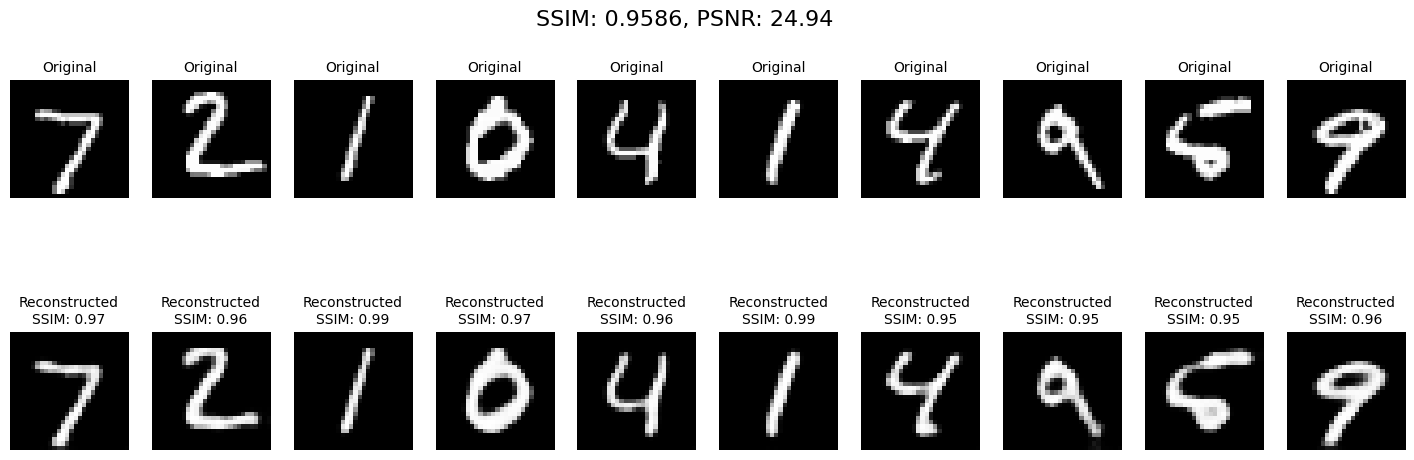

In [ ]:
visualize_reconstructions()


### Latent space visulization

In [14]:
def visualize_latent_space():
    # Load the trained model
    autoencoder = Autoencoder(latent_dim=Config.LATENT_DIM).to(Config.DEVICE)
    autoencoder.load_state_dict(torch.load(os.path.join(Config.SAVE_DIR, Config.MODEL_NAME)))
    autoencoder.eval()

    # Load the test data
    test_loader = get_mnist_dataloader(train=True)
    images, labels = next(iter(test_loader))
    images = images.to(Config.DEVICE)
    labels = labels.cpu().numpy()  # Move labels to CPU for visualization

    # Encode the images to the latent space
    with torch.no_grad():
        latents = autoencoder.encode(images).cpu().numpy()

    # Reduce dimensions to 2D using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    latents_2d = tsne.fit_transform(latents)

    # Create a scatter plot with labels
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap="tab10", s=40, alpha=0.8)
    plt.colorbar(scatter, label="Digit Label")

    # Annotate each point with its digit label
    for i, label in enumerate(labels):
        plt.annotate(str(label), (latents_2d[i, 0], latents_2d[i, 1]),
                     textcoords="offset points", xytext=(0, 2), ha='center', fontsize=8, color='black')

    plt.title("Latent Space Visualization with Labels", fontsize=16)
    plt.xlabel("Dimension 1", fontsize=12)
    plt.ylabel("Dimension 2", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


In [ ]:
#######

In [ ]:
######## careful #######

In [ ]:
#######

<ipython-input-19-19b3b8b4e12a>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(os.path.join(Config.SAVE_DIR, Config.MODEL_NAME)))


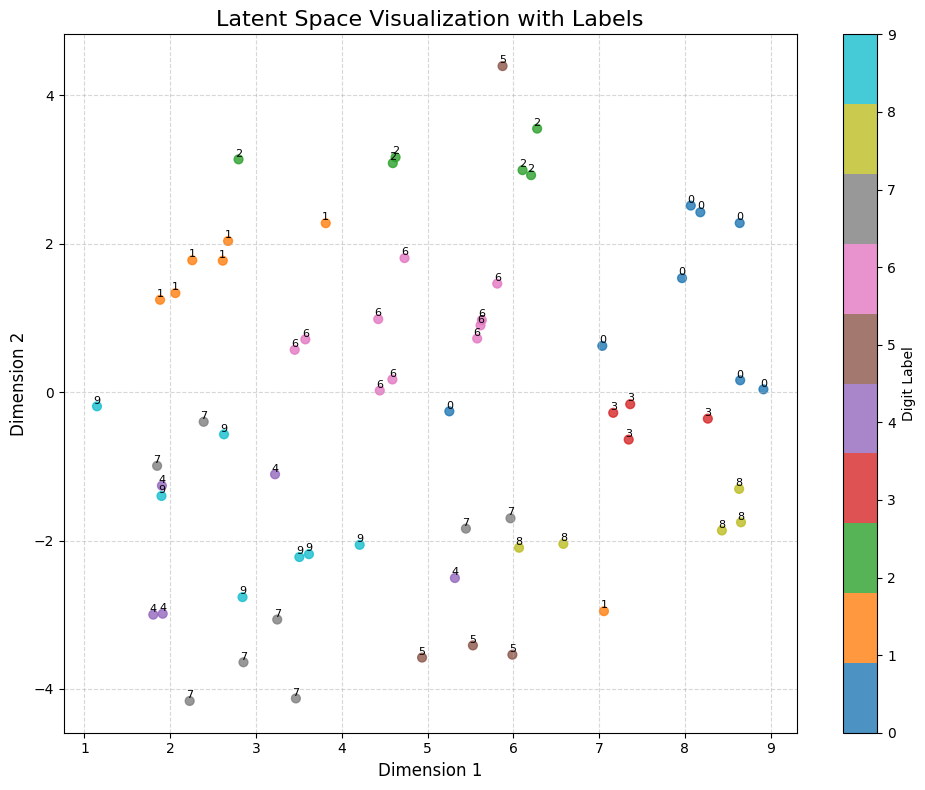

In [ ]:
visualize_latent_space()

In [15]:
def visualize_latent_space():
    # Load the trained model
    autoencoder = Autoencoder(latent_dim=Config.LATENT_DIM).to(Config.DEVICE)
    load_path = os.path.join(Config.SAVE_DIR, Config.MODEL_NAME)
    autoencoder.load_state_dict(torch.load(load_path, map_location=Config.DEVICE))
    autoencoder.eval()

    # Load the test data
    test_loader = get_mnist_dataloader(train=False)
    test_images, test_labels = next(iter(test_loader))
    test_images = test_images.to(Config.DEVICE)
    test_labels = test_labels.cpu().numpy()  # Move labels to CPU for visualization

    # Encode the images to the latent space
    with torch.no_grad():
        latents = autoencoder.encode(test_images).cpu().numpy()

    # Reduce dimensions to 2D using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    latents_2d = tsne.fit_transform(latents)

    # Create a scatter plot with annotations
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=test_labels, cmap="tab10", s=40, alpha=0.8)
    plt.colorbar(scatter, label="Digit Label")

    # Annotate each point with its digit label
    for i, label in enumerate(test_labels):
        plt.annotate(
            str(label),
            (latents_2d[i, 0], latents_2d[i, 1]),
            textcoords="offset points",
            xytext=(0, 2),
            ha="center",
            fontsize=8,
            color="black",
        )

    plt.title("Latent Space Visualization (Single Test Batch) with Labels", fontsize=16)
    plt.xlabel("Dimension 1", fontsize=12)
    plt.ylabel("Dimension 2", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # # Entire training dataset
    # visualize_latent_space_full(
    #     autoencoder,
    #     get_mnist_dataloader(train=True),
    #     title="Latent Space Visualization (Entire Training Dataset)",
    #     save_path=os.path.join(Config.SAVE_DIR, "latent_space_train.png"),
    # )

    # Entire test dataset
    visualize_latent_space_full(
        autoencoder,
        test_loader,
        title="Latent Space Visualization (Entire Test Dataset)",
        save_path=os.path.join(Config.SAVE_DIR, "latent_space_test.png"),
    )


In [ ]:
#######

In [ ]:
######## careful #######

In [ ]:
#######

<ipython-input-23-e977b402ca11>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(load_path, map_location=Config.DEVICE))


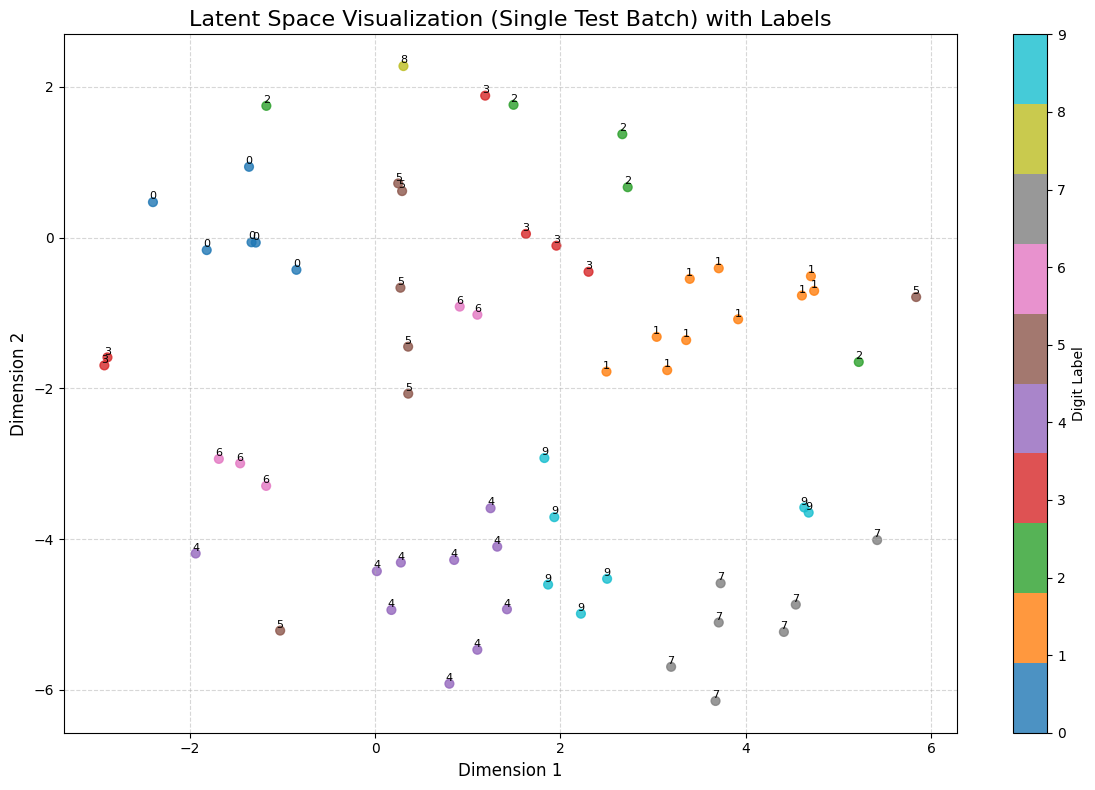

Encoding Latent Space Visualization (Entire Test Dataset): 100%|██████████| 157/157 [00:01<00:00, 128.60it/s]


Saved visualization to /content/drive/My Drive/AI/Projects/diffusion mnist/models/latent_space_test.png


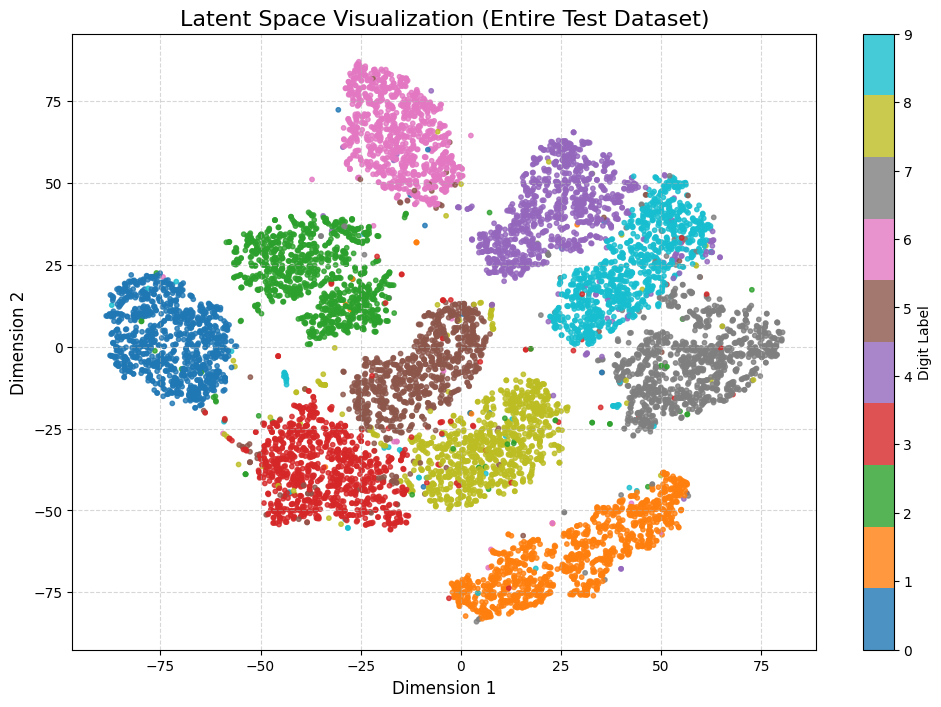

In [ ]:
visualize_latent_space()

## Denoising Diffusion Probabilistic Model implementation

### V1

In [ ]:
!pip install torch torchvision einops matplotlib tqdm torchsummary torchviz


In [ ]:
import math
from collections.abc import Callable
import torch
from einops import rearrange
from torch import nn
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [ ]:
class GQA(nn.Module): ## Grouped Query Attention (GQA)
    def __init__(
        self,
        hidden_dim: int,
        num_heads: int,
        num_groups: int,
        rope_fn: Callable,
    ):
        super().__init__()

        assert hidden_dim % num_heads == 0, "hidden_dim must be divisible by num_heads."
        assert (
            hidden_dim % num_groups == 0
        ), "hidden_dim must be divisible by num_groups."
        assert num_heads % num_groups == 0, "num_heads must be divisible by num_groups."

        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.num_groups = num_groups

        self.qdim = hidden_dim // num_heads  # = d_q
        self.kvdim = hidden_dim // num_groups  # = d_kv

        self.rope_fn = rope_fn

        self.q_proj = nn.Linear(hidden_dim, hidden_dim)
        self.k_proj = nn.Linear(hidden_dim, hidden_dim)
        self.v_proj = nn.Linear(hidden_dim, hidden_dim)

        self.out = nn.Linear(hidden_dim, hidden_dim)

    def forward(
        self,
        x: torch.Tensor,  # [b, s, hidden_dim]
        attn_mask: torch.Tensor = None,  # [b, s] or [b, 1, s, s]
    ):

        b, s, _ = x.shape

        q = self.q_proj(x)  # [b, s, d_model]
        k = self.k_proj(x)  # [b, s, d_model]
        v = self.v_proj(x)  # [b, s, d_model]

        q = self.rope_fn(q)  # [b, s, d_model]
        k = self.rope_fn(k)  # [b, s, d_model]

        q = rearrange(q, "b s (h d) -> b s h d", h=self.num_heads)

        q = rearrange(q, "b s (g subh) d -> b g subh s d", g=self.num_groups)

        k = rearrange(k, "b s (g d) -> b g s d", g=self.num_groups)
        v = rearrange(v, "b s (g d) -> b g s d", g=self.num_groups)

        k_t = k.transpose(-2, -1)  # [b, G, d_kv, s]
        e = torch.einsum("b g subh s d, b g d s -> b g subh s s", q, k_t)
        e = e / math.sqrt(self.qdim)

        if attn_mask is not None:
            mask_5d = attn_mask.unsqueeze(1).unsqueeze(2).unsqueeze(3)
            mask_5d = mask_5d.expand(-1, self.num_groups, q.shape[2], s, -1)
            e = e.masked_fill(mask_5d == 0, float("-inf"))

        attn_weights = torch.softmax(e, dim=-1)

        out = torch.einsum("b g subh s s, b g s d -> b g subh s d", attn_weights, v)

        out = rearrange(out, "b g subh s d -> b s (g subh d)")

        out = self.out(out)
        return out


class TransformerBlock(nn.Module):
    def __init__(self, hidden_dim: int, emb_dim: int, num_heads: int, num_groups: int, rope_fn: Callable):
        super().__init__()

        self.gqa = GQA(
            hidden_dim=emb_dim,
            num_heads=num_heads,
            num_groups=num_groups,
            rope_fn=rope_fn,
        )

        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, emb_dim),
        )

        self.norm1 = nn.LayerNorm(emb_dim)
        self.norm2 = nn.LayerNorm(emb_dim)

    def forward(self, x: torch.Tensor):
        attn_out = self.gqa(x)

        out = self.norm1(x + attn_out)
        out = self.mlp(out)

        return self.norm2(x + out)


class DiffusionTransformer(nn.Module):
    def __init__(
        self,
        emb_dim: int,
        latent_dim: int,
        hidden_dim: int,
        num_groups: int,
        num_heads: int,
        num_blocks: int,
        rope_fn: Callable,
    ):
        super().__init__()
        self.input_proj = nn.Linear(latent_dim, emb_dim)

        self.time_emb = nn.Linear(1, emb_dim)
        self.blocks = nn.ModuleList(
            [
                TransformerBlock(
                    emb_dim=emb_dim,
                    hidden_dim=hidden_dim,
                    num_heads=num_heads,
                    num_groups=num_groups,
                    rope_fn=rope_fn,
                )
                for _ in range(num_blocks)
            ]
        )

        self.output_proj = nn.Linear(emb_dim, latent_dim)

    def forward(self, latents: torch.Tensor, t: int):
        """
        latents: b, e
        t: b
        """
        t = rearrange(t, "b -> b 1").float()
        t_emb = self.time_emb(t)

        x = self.input_proj(latents)  # b e

        x = rearrange(x, "b e -> b 1 e")
        t_emb = rearrange(t_emb, "b d -> b 1 d")
        print(f"x shape: {x.shape}, t_emb shape: {t_emb.shape}")

        x = x + t_emb

        for block in self.blocks:
            x = block(x)

        out = self.output_proj(x)
        out = rearrange(out, "b 1 e -> b e")

        return out


In [ ]:
def sinusoidal_position_encoding(x):

    batch_size, seq_len, emb_dim = x.shape
    position = torch.arange(seq_len, dtype=torch.float, device=x.device).unsqueeze(1)
    div_term = torch.exp(-math.log(10000.0) * torch.arange(0, emb_dim, 2, dtype=torch.float, device=x.device) / emb_dim)


    pos_enc = torch.zeros(seq_len, emb_dim, device=x.device)
    pos_enc[:, 0::2] = torch.sin(position * div_term)
    pos_enc[:, 1::2] = torch.cos(position * div_term)

    return x + pos_enc.unsqueeze(0)

In [ ]:
class LatentDiffusion(nn.Module):
    def __init__(
        self, transformer: nn.Module, timesteps: int, beta_start: float, beta_end: float
    ):
        super().__init__()
        self.transformer = transformer
        self.timesteps = timesteps

        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        alphas = 1 - self.betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        self.register_buffer("self_betas", self.betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)
        self.register_buffer(
            "alphas_cumprod_prev",
            torch.cat([alphas_cumprod.new_ones(1), alphas_cumprod[:-1]]),
        )
        self.register_buffer("sqrt_alphas_cumprod", torch.sqrt(alphas_cumprod))
        self.register_buffer(
            "sqrt_one_minus_alphas_cumprod", torch.sqrt(1.0 - alphas_cumprod)
        )

    def q_sample(self, x_start, t, noise=None):
        """
        Diffusion forward process: x_t = sqrt_alpha_cumprod * x_0 + sqrt(1 - alpha_cumprod) * noise
        """
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alpha_cumprod_t = self.extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alpha_cumprod_t = self.extract(
            self.sqrt_one_minus_alphas_cumprod, t, x_start.shape
        )

        return sqrt_alpha_cumprod_t * x_start + sqrt_one_minus_alpha_cumprod_t * noise

    def training_step(self, x_0):
        """
        1. sample random t
        2. sample noise
        3. generate x_t
        4. predict noise with transformer
        5. compute loss
        """

        b = x_0.shape[0]
        device = x_0.device

        t = torch.randint(0, self.timesteps, (b,), device=device).long()

        noise = torch.randn_like(x_0)
        x_t = self.q_sample(x_0, t)

        noise_pred = self.transformer(x_t, t)
        loss = F.mse_loss(noise, noise_pred)

        return loss

    def extract(self, a: torch.Tensor, t: torch.Tensor, x_shape: tuple):
        out = a.gather(-1, t)
        return out.view(-1, *[1] * (len(x_shape) - 1))

    def p_sample(self, x_t: torch.Tensor, t: torch.Tensor):
        """
        Reverse process: x_{t-1} ~ N(mu_theta(x_t, t), sigma_t^2 I)
        """

        betas_t = self.extract(self.betas, t, x_t.shape)
        sqrt_one_minus_alphas_cumprod_t = self.extract(
            self.sqrt_one_minus_alphas_cumprod, t, x_t.shape
        )
        sqrt_alphas_cumprod_t = self.extract(self.sqrt_alphas_cumprod, t, x_t.shape)

        noise_pred = self.transformer(x_t, t)

        # x_{t-1} = 1/sqrt(alpha_t) * ( x_t - (1 - alpha_t) * noise_pred / sqrt(1 - alpha_cumprod_t) ) + sqrt(beta_t) * z
        alpha_t = 1.0 - betas_t
        sqrt_alpha_t = torch.sqrt(alpha_t)

        mu = (1.0 / sqrt_alpha_t) * (
            x_t - betas_t / sqrt_one_minus_alphas_cumprod_t * noise_pred
        )

        sigma_t = torch.sqrt(betas_t)

        # Random noise, except if t=0
        z = torch.randn_like(x_t)

        # If t=0, no noise
        mask = (t > 0).float().unsqueeze(-1)
        x_prev = mu + mask * sigma_t * z

        return x_prev

    @torch.no_grad()
    def p_sample_loop(self, shape: tuple, device: str):
        b = shape[0]

        x = torch.randn_like(shape, device=device)

        for i in reversed(range(self.timesteps)):
            t = torch.full(i, (b,), device=device)
            x = self.p_sample(x, t)

        return x

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        return self.transformer(x, t)


In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.sum = 0
        self.count = 0

    @property
    def avg(self):
        return self.sum / max(1, self.count)

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n


def save_checkpoint(state, filename):
    torch.save(state, filename)
    print(f"Checkpoint saved: {filename}")


In [ ]:
def train_model(epochs: int, batch_size: int, lr: float):
    device = Config.DEVICE
    Config.EPOCHS = epochs
    Config.BATCH_SIZE = batch_size
    Config.LR = lr

    train_loader = get_mnist_dataloader(train=True)

    # Load pre-trained autoencoder
    autoencoder = Autoencoder(latent_dim=Config.LATENT_DIM).to(Config.DEVICE)
    autoencoder_path = os.path.join(Config.SAVE_DIR, Config.AUTOENCODER_MODEL_NAME)
    if not os.path.exists(autoencoder_path):
        raise FileNotFoundError(f"Pretrained autoencoder model not found at {autoencoder_path}")
    autoencoder.load_state_dict(torch.load(autoencoder_path, map_location=Config.DEVICE))


    diffusion_transformer = DiffusionTransformer(
        emb_dim=Config.TRANSFORMER_EMBED_DIM,
        latent_dim=Config.LATENT_DIM,
        hidden_dim=Config.TRANSFORMER_HIDDEN_DIM,
        num_groups=Config.TRANSFORMER_NUM_GROUPS,
        num_heads=Config.TRANSFORMER_NUM_HEADS,
        num_blocks=Config.TRANSFORMER_NUM_BLOCKS,
        rope_fn=Config.ROPE_FN,
    ).to(device)

    diffusion_model = LatentDiffusion(
        transformer=diffusion_transformer,
        timesteps=Config.TIMESTEPS,
        beta_start=Config.BETA_START,
        beta_end=Config.BETA_END,
    ).to(device)

    ae_optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
    diffusion_optimizer = optim.Adam(diffusion_model.parameters(), lr=lr)

    autoencoder.train()
    diffusion_model.train()
    print("Starting joint autoencoder + diffusion model training...")

    loss_history = []
    for epoch in range(epochs):
        loss_meter = AverageMeter()
        pbar = tqdm(
            train_loader,
            desc=f"[Joint Diffusion] Epoch {epoch+1}/{epochs}",
            leave=False,
        )
        for images, _ in pbar:
            images = images.to(device)
            latents = autoencoder.encode(images)
            loss = diffusion_model.training_step(latents)

            diffusion_optimizer.zero_grad()
            ae_optimizer.zero_grad()
            loss.backward()
            diffusion_optimizer.step()
            ae_optimizer.step()

            loss_meter.update(loss.item(), images.size(0))
            pbar.set_postfix({"loss": f"{loss_meter.avg:.4f}"})

        loss_history.append(loss_meter.avg)
        print(f"[Joint Diffusion] Epoch [{epoch+1}/{epochs}] - Diffusion Loss: {loss_meter.avg:.4f}")

        checkpoint_dir = os.path.join(Config.SAVE_DIR, "checkpoints")
        os.makedirs(checkpoint_dir, exist_ok=True)
        save_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pth")
        os.makedirs("checkpoints", exist_ok=True)
        save_checkpoint(
            {
                "epoch": epoch + 1,
                "autoencoder_state": autoencoder.state_dict(),
                "diffusion_state": diffusion_model.state_dict(),
                "ae_optimizer_state": ae_optimizer.state_dict(),
                "diffusion_optimizer_state": diffusion_optimizer.state_dict(),
            },
            save_path,
        )
        print(f"Checkpoint saved: {save_path}")
    print("Joint diffusion training completed.")

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
class Config:
    DATASET_NAME = "MNIST"
    IMAGE_SIZE = 28
    LATENT_DIM = 64
    SAVE_DIR = "/content/drive/My Drive/AI/Projects/diffusion mnist/models"
    AUTOENCODER_MODEL_NAME = "Autoencoder_with_CAB.pth"
    DDPM_MODEL_NAME = "DDMP_1.pth"
    BATCH_SIZE = 64
    EPOCHS = 10
    LR = 1e-4
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Encoder/Decoder Configurations
    ENCODER_CHANNELS = [1, 16, 32]
    DECODER_CHANNELS = [32, 16, 1]
    NUM_CABS_ENCODER = [1, 0]
    NUM_CABS_DECODER = [1, 0]
    REDUCTION_FACTOR = 8
    DEBUG = False

    # Diffusion model configurations
    TIMESTEPS = 1_000
    BETA_START = 0.0001
    BETA_END = 0.02

    # Transformer configurations
    TRANSFORMER_EMBED_DIM = 64
    TRANSFORMER_NUM_HEADS = 4
    TRANSFORMER_HIDDEN_DIM = 128
    TRANSFORMER_NUM_BLOCKS = 4  # Renamed from TRANSFORMER_NUM_LAYERS
    TRANSFORMER_NUM_GROUPS = 2  # New: Number of groups for GQA

    # Positional Encoding (Optional)
    ROPE_FN = sinusoidal_position_encoding  # Use sinusoidal positional encoding by default

In [ ]:
train_model(epochs=Config.EPOCHS, batch_size=Config.BATCH_SIZE, lr=Config.LR)

<ipython-input-73-7137eeab6ccc>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(autoencoder_path, map_location=Config.DEVICE))


Starting joint autoencoder + diffusion model training...


x shape: torch.Size([64, 1, 64]), t_emb shape: torch.Size([64, 1, 64])


RuntimeError: einsum(): the number of subscripts in the equation (8) does not match the number of dimensions (5) for operand 0 and no ellipsis was given

In [ ]:


@torch.no_grad()
def sample_images(ckpt_path, num_samples=16):
    checkpoint = torch.load(ckpt_path, map_location=Config.DEVICE)

    autoencoder = Autoencoder(
        image_size=Config.IMAGE_SIZE, latent_dim=Config.LATENT_DIM
    ).to(Config.DEVICE)
    diffusion_transformer = DiffusionTransformer(
        latent_dim=Config.LATENT_DIM,
        embed_dim=Config.TRANSFORMER_EMBED_DIM,
        num_heads=Config.TRANSFORMER_NUM_HEADS,
        hidden_dim=Config.TRANSFORMER_HIDDEN_DIM,
        num_layers=Config.TRANSFORMER_NUM_LAYERS,
    ).to(Config.DEVICE)
    diffusion_model = LatentDiffusion(
        transformer=diffusion_transformer,
        timesteps=Config.TIMESTEPS,
        beta_start=Config.BETA_START,
        beta_end=Config.BETA_END,
    ).to(Config.DEVICE)

    # Load state
    autoencoder.load_state_dict(checkpoint["autoencoder_state"])
    diffusion_model.load_state_dict(checkpoint["diffusion_state"])

    # Generate latents from scratch
    latents = diffusion_model.p_sample_loop(
        shape=(num_samples, Config.LATENT_DIM), device=Config.DEVICE
    )
    # Decode to images
    images = autoencoder.decode(latents)

    # Plot a grid of generated images
    images = images.cpu().detach()
    os.makedirs("samples", exist_ok=True)
    plt.figure(figsize=(8, 8))
    for i in range(num_samples):
        plt.subplot(int(num_samples**0.5), int(num_samples**0.5), i + 1)
        plt.imshow(images[i][0], cmap="gray")
        plt.axis("off")
    sample_file = "samples/generated_samples.png"
    plt.tight_layout()
    plt.savefig(sample_file)
    print(f"Samples saved to {sample_file}")
    plt.close()


### V2

In [ ]:
import torch

T=1000   # 加噪最大步数

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.38MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

5


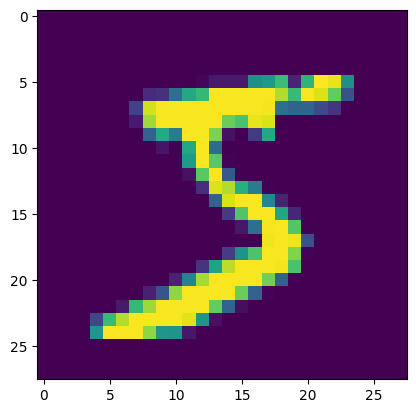

In [ ]:
from torch.utils.data import Dataset
from torchvision.transforms.v2 import PILToTensor,Compose
import torchvision
from torchvision import datasets, transforms

def get_transforms():
    return transforms.Compose([
        transforms.ToTensor(),
    ])

# def get_mnist_dataloader(train=True):
#     dataset = datasets.MNIST(
#         root="./data", train=train, download=True, transform=get_transforms()
#     )
#     dataloader = DataLoader(dataset, batch_size=Config.BATCH_SIZE, shuffle=train)
#     return dataloader

# 手写数字
class MNIST(Dataset):
    def __init__(self,is_train=True):
        super().__init__()
        self.ds=torchvision.datasets.MNIST('./data',train=is_train, transform=get_transforms(), download=True)

    def __len__(self):
        return len(self.ds)

    def __getitem__(self,index):
        return self.ds[index]

if __name__=='__main__':
    import matplotlib.pyplot as plt

    ds=MNIST()
    img,label=ds[0]
    print(label)
    plt.imshow(img.permute(1,2,0))
    plt.show()

In [ ]:
import torch

T=1000   # 加噪最大步数

In [ ]:
import torch
from torch import nn
import math

class TimeEmbedding(nn.Module):
    def __init__(self,emb_size):
        super().__init__()
        self.half_emb_size=emb_size//2
        half_emb=torch.exp(torch.arange(self.half_emb_size)*(-1*math.log(10000)/(self.half_emb_size-1)))
        self.register_buffer('half_emb',half_emb)

    def forward(self,t):
        t=t.view(t.size(0),1)
        half_emb=self.half_emb.unsqueeze(0).expand(t.size(0),self.half_emb_size)
        half_emb_t=half_emb*t
        embs_t=torch.cat((half_emb_t.sin(),half_emb_t.cos()),dim=-1)
        return embs_t

if __name__=='__main__':
    time_emb=TimeEmbedding(16)
    t=torch.randint(0,T,(2,))   # 随机2个图片的t时间步
    embs=time_emb(t)
    print(embs)

tensor([[ 0.9614, -0.6703,  0.9976,  0.7827,  0.9373,  0.4942,  0.1382,  0.0372,
          0.2751,  0.7420, -0.0687,  0.6224, -0.3485,  0.8694,  0.9904,  0.9993],
        [-0.0088,  0.9797, -0.9197,  0.1455,  0.9882,  0.4464,  0.1238,  0.0333,
          1.0000,  0.2002,  0.3927,  0.9894, -0.1534,  0.8948,  0.9923,  0.9994]])


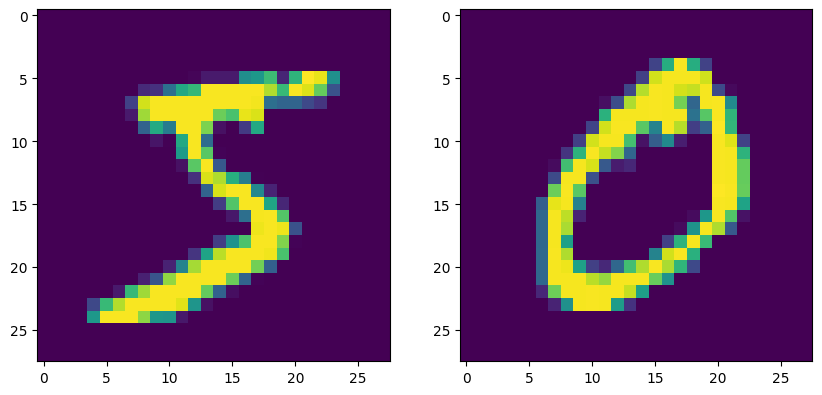

t: tensor([271, 726])
x: torch.Size([2, 1, 28, 28])
noise: torch.Size([2, 1, 28, 28])


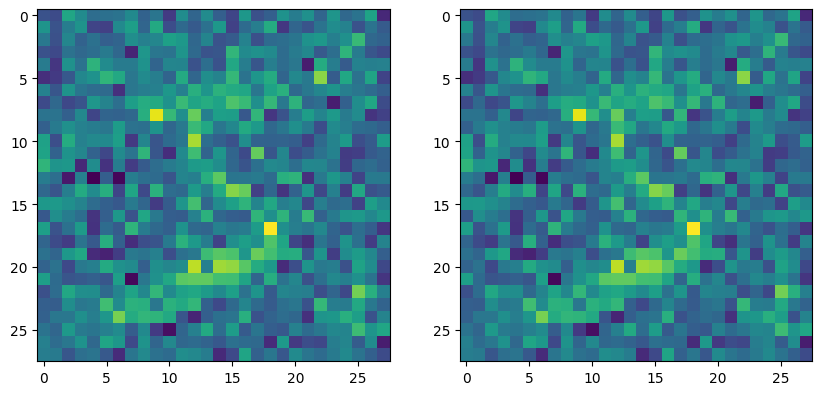

In [ ]:
import torch


# 前向diffusion计算参数
betas=torch.linspace(0.0001,0.02,T) # (T,)
alphas=1-betas  # (T,)
alphas_cumprod=torch.cumprod(alphas,dim=-1) # alpha_t累乘 (T,)    [a1,a2,a3,....] ->  [a1,a1*a2,a1*a2*a3,.....]
alphas_cumprod_prev=torch.cat((torch.tensor([1.0]),alphas_cumprod[:-1]),dim=-1) # alpha_t-1累乘 (T,),  [1,a1,a1*a2,a1*a2*a3,.....]
variance=(1-alphas)*(1-alphas_cumprod_prev)/(1-alphas_cumprod)  # denoise用的方差   (T,)

# 执行前向加噪
def forward_add_noise(x,t): # batch_x: (batch,channel,height,width), batch_t: (batch_size,)
    noise=torch.randn_like(x)   # 为每张图片生成第t步的高斯噪音   (batch,channel,height,width)
    batch_alphas_cumprod=alphas_cumprod[t].view(x.size(0),1,1,1)
    x=torch.sqrt(batch_alphas_cumprod)*x+torch.sqrt(1-batch_alphas_cumprod)*noise # 基于公式直接生成第t步加噪后图片
    return x,noise

if __name__=='__main__':
    import matplotlib.pyplot as plt

    dataset=MNIST()

    x=torch.stack((dataset[0][0],dataset[1][0]),dim=0) # 2个图片拼batch, (2,1,48,48)

    # 原图
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(x[0].permute(1,2,0))
    plt.subplot(1,2,2)
    plt.imshow(x[1].permute(1,2,0))
    plt.show()

    # 随机时间步
    t=torch.randint(0,T,size=(x.size(0),))
    print('t:',t)

    # 加噪
    x=x*2-1 # [0,1]像素值调整到[-1,1]之间,以便与高斯噪音值范围匹配
    x,noise=forward_add_noise(x,t)
    print('x:',x.size())
    print('noise:',noise.size())

    # 加噪图
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(((x[0]+1)/2).permute(1,2,0))
    plt.subplot(1,2,2)
    plt.imshow(((x[0]+1)/2).permute(1,2,0))
    plt.show()

In [ ]:
from torch import nn
import torch
import math

class DiTBlock(nn.Module):
    def __init__(self,emb_size,nhead):
        super().__init__()

        self.emb_size=emb_size
        self.nhead=nhead

        # conditioning
        self.gamma1=nn.Linear(emb_size,emb_size)
        self.beta1=nn.Linear(emb_size,emb_size)
        self.alpha1=nn.Linear(emb_size,emb_size)
        self.gamma2=nn.Linear(emb_size,emb_size)
        self.beta2=nn.Linear(emb_size,emb_size)
        self.alpha2=nn.Linear(emb_size,emb_size)

        # layer norm
        self.ln1=nn.LayerNorm(emb_size)
        self.ln2=nn.LayerNorm(emb_size)

        # multi-head self-attention
        self.wq=nn.Linear(emb_size,nhead*emb_size) # (batch,seq_len,nhead*emb_size)
        self.wk=nn.Linear(emb_size,nhead*emb_size) # (batch,seq_len,nhead*emb_size)
        self.wv=nn.Linear(emb_size,nhead*emb_size) # (batch,seq_len,nhead*emb_size)
        self.lv=nn.Linear(nhead*emb_size,emb_size)

        # feed-forward
        self.ff=nn.Sequential(
            nn.Linear(emb_size,emb_size*4),
            nn.ReLU(),
            nn.Linear(emb_size*4,emb_size)
        )

    def forward(self,x,cond):   # x:(batch,seq_len,emb_size), cond:(batch,emb_size)
        # conditioning (batch,emb_size)
        gamma1_val=self.gamma1(cond)
        beta1_val=self.beta1(cond)
        alpha1_val=self.alpha1(cond)
        gamma2_val=self.gamma2(cond)
        beta2_val=self.beta2(cond)
        alpha2_val=self.alpha2(cond)

        # layer norm
        y=self.ln1(x) # (batch,seq_len,emb_size)

        # scale&shift
        y=y*(1+gamma1_val.unsqueeze(1))+beta1_val.unsqueeze(1)

        # attention
        q=self.wq(y)    # (batch,seq_len,nhead*emb_size)
        k=self.wk(y)    # (batch,seq_len,nhead*emb_size)
        v=self.wv(y)    # (batch,seq_len,nhead*emb_size)
        q=q.view(q.size(0),q.size(1),self.nhead,self.emb_size).permute(0,2,1,3) # (batch,nhead,seq_len,emb_size)
        k=k.view(k.size(0),k.size(1),self.nhead,self.emb_size).permute(0,2,3,1) # (batch,nhead,emb_size,seq_len)
        v=v.view(v.size(0),v.size(1),self.nhead,self.emb_size).permute(0,2,1,3) # (batch,nhead,seq_len,emb_size)
        attn=q@k/math.sqrt(q.size(2))   # (batch,nhead,seq_len,seq_len)
        attn=torch.softmax(attn,dim=-1)   # (batch,nhead,seq_len,seq_len)
        y=attn@v    # (batch,nhead,seq_len,emb_size)
        y=y.permute(0,2,1,3) # (batch,seq_len,nhead,emb_size)
        y=y.reshape(y.size(0),y.size(1),y.size(2)*y.size(3))    # (batch,seq_len,nhead*emb_size)
        y=self.lv(y)    # (batch,seq_len,emb_size)

        # scale
        y=y*alpha1_val.unsqueeze(1)
        # redisual
        y=x+y

        # layer norm
        z=self.ln2(y)
        # scale&shift
        z=z*(1+gamma2_val.unsqueeze(1))+beta2_val.unsqueeze(1)
        # feef-forward
        z=self.ff(z)
        # scale
        z=z*alpha2_val.unsqueeze(1)
        # residual
        return y+z

if __name__=='__main__':
    dit_block=DiTBlock(emb_size=16,nhead=4)

    x=torch.rand((5,49,16))
    cond=torch.rand((5,16))

    outputs=dit_block(x,cond)
    print(outputs.shape)

torch.Size([5, 49, 16])


In [ ]:
from torch import nn
import torch

class DiT(nn.Module):
    def __init__(self,img_size,patch_size,channel,emb_size,label_num,dit_num,head):
        super().__init__()

        self.patch_size=patch_size
        self.patch_count=img_size//self.patch_size
        self.channel=channel

        # patchify
        self.conv=nn.Conv2d(in_channels=channel,out_channels=channel*patch_size**2,kernel_size=patch_size,padding=0,stride=patch_size)
        self.patch_emb=nn.Linear(in_features=channel*patch_size**2,out_features=emb_size)
        self.patch_pos_emb=nn.Parameter(torch.rand(1,self.patch_count**2,emb_size))

        # time emb
        self.time_emb=nn.Sequential(
            TimeEmbedding(emb_size),
            nn.Linear(emb_size,emb_size),
            nn.ReLU(),
            nn.Linear(emb_size,emb_size)
        )

        # label emb
        self.label_emb=nn.Embedding(num_embeddings=label_num,embedding_dim=emb_size)

        # DiT Blocks
        self.dits=nn.ModuleList()
        for _ in range(dit_num):
            self.dits.append(DiTBlock(emb_size,head))

        # layer norm
        self.ln=nn.LayerNorm(emb_size)

        # linear back to patch
        self.linear=nn.Linear(emb_size,channel*patch_size**2)

    def forward(self,x,t,y): # x:(batch,channel,height,width)   t:(batch,)  y:(batch,)
        # label emb
        y_emb=self.label_emb(y) #   (batch,emb_size)
        # time emb
        t_emb=self.time_emb(t)  #   (batch,emb_size)

        # condition emb
        cond=y_emb+t_emb

        # patch emb
        x=self.conv(x)  # (batch,new_channel,patch_count,patch_count)
        x=x.permute(0,2,3,1)    # (batch,patch_count,patch_count,new_channel)
        x=x.view(x.size(0),self.patch_count*self.patch_count,x.size(3)) # (batch,patch_count**2,new_channel)

        x=self.patch_emb(x) # (batch,patch_count**2,emb_size)
        x=x+self.patch_pos_emb # (batch,patch_count**2,emb_size)

        # dit blocks
        for dit in self.dits:
            x=dit(x,cond)

        # # layer norm
        x=self.ln(x)    #   (batch,patch_count**2,emb_size)

        # # linear back to patch
        x=self.linear(x)    # (batch,patch_count**2,channel*patch_size*patch_size)

        # reshape
        x=x.view(x.size(0),self.patch_count,self.patch_count,self.channel,self.patch_size,self.patch_size)  # (batch,patch_count,patch_count,channel,patch_size,patch_size)
        x=x.permute(0,3,1,2,4,5)    # (batch,channel,patch_count(H),patch_count(W),patch_size(H),patch_size(W))
        x=x.permute(0,1,2,4,3,5)    # (batch,channel,patch_count(H),patch_size(H),patch_count(W),patch_size(W))
        x=x.reshape(x.size(0),self.channel,self.patch_count*self.patch_size,self.patch_count*self.patch_size)   # (batch,channel,img_size,img_size)
        return x

if __name__=='__main__':
    dit=DiT(img_size=28,patch_size=4,channel=1,emb_size=64,label_num=10,dit_num=3,head=4)
    x=torch.rand(5,1,28,28)
    t=torch.randint(0,T,(5,))
    y=torch.randint(0,10,(5,))
    outputs=dit(x,t,y)
    print(outputs.shape)

torch.Size([5, 1, 28, 28])


In [ ]:
import torch

import math


class TimeEmbedding(nn.Module):
    def __init__(self,emb_size):
        super().__init__()
        self.half_emb_size=emb_size//2
        half_emb=torch.exp(torch.arange(self.half_emb_size)*(-1*math.log(10000)/(self.half_emb_size-1)))
        self.register_buffer('half_emb',half_emb)

    def forward(self,t):
        t=t.view(t.size(0),1)
        half_emb=self.half_emb.unsqueeze(0).expand(t.size(0),self.half_emb_size)
        half_emb_t=half_emb*t
        embs_t=torch.cat((half_emb_t.sin(),half_emb_t.cos()),dim=-1)
        return embs_t

if __name__=='__main__':
    time_emb=TimeEmbedding(16)
    t=torch.randint(0,T,(2,))   # 随机2个图片的t时间步
    embs=time_emb(t)
    print(embs)

tensor([[-0.4441, -0.9770,  0.8488, -0.8160,  0.9900,  0.3742,  0.1027,  0.0276,
          0.8960,  0.2133,  0.5287,  0.5781,  0.1408,  0.9274,  0.9947,  0.9996],
        [-0.8462,  0.8916, -0.9455,  0.1264,  0.9890,  0.4451,  0.1234,  0.0332,
          0.5329,  0.4528,  0.3256,  0.9920, -0.1482,  0.8955,  0.9924,  0.9994]])


In [ ]:
from torch.utils.data import DataLoader
import torch
from torch import nn
import os

DEVICE='cuda' if torch.cuda.is_available() else 'cpu' # 设备

dataset=MNIST() # 数据集

model=DiT(img_size=28,patch_size=4,channel=1,emb_size=64,label_num=10,dit_num=3,head=4).to(DEVICE) # 模型

try:    # 加载模型
    model.load_state_dict(torch.load('model.pth'))
except:
    pass

optimzer=torch.optim.Adam(model.parameters(),lr=1e-3)   # 优化器

loss_fn=nn.L1Loss() # 损失函数(绝对值误差均值)

'''
    训练模型
'''

EPOCH=500
BATCH_SIZE=300

dataloader=DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=10,persistent_workers=True)    # 数据加载器

model.train()

iter_count=0
for epoch in range(EPOCH):
    for imgs,labels in dataloader:
        x=imgs*2-1 # 图像的像素范围从[0,1]转换到[-1,1],和噪音高斯分布范围对应
        t=torch.randint(0,T,(imgs.size(0),))  # 为每张图片生成随机t时刻
        y=labels

        x,noise=forward_add_noise(x,t) # x:加噪图 noise:噪音
        pred_noise=model(x.to(DEVICE),t.to(DEVICE),y.to(DEVICE))

        loss=loss_fn(pred_noise,noise.to(DEVICE))

        optimzer.zero_grad()
        loss.backward()
        optimzer.step()

        if iter_count%1000==0:
            print('epoch:{} iter:{},loss:{}'.format(epoch,iter_count,loss))
            torch.save(model.state_dict(),'.model.pth')
            os.replace('.model.pth','model.pth')
        iter_count+=1

<ipython-input-14-9b3b741bfa37>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))
/usr/local/lib/python3.10/dist-packages/torc

epoch:0 iter:0,loss:0.9166432023048401
epoch:5 iter:1000,loss:0.11062053591012955
epoch:10 iter:2000,loss:0.08824752271175385
epoch:15 iter:3000,loss:0.0777934193611145
epoch:20 iter:4000,loss:0.07402250915765762
epoch:25 iter:5000,loss:0.08156365156173706
epoch:30 iter:6000,loss:0.06683821231126785
epoch:35 iter:7000,loss:0.06881406158208847
epoch:40 iter:8000,loss:0.06507676839828491
epoch:45 iter:9000,loss:0.06462212651968002
epoch:50 iter:10000,loss:0.0630328357219696
epoch:55 iter:11000,loss:0.06328461319208145
epoch:60 iter:12000,loss:0.057121723890304565
epoch:65 iter:13000,loss:0.05699710547924042
epoch:70 iter:14000,loss:0.055862314999103546
epoch:75 iter:15000,loss:0.05558150261640549
epoch:80 iter:16000,loss:0.05282212793827057
epoch:85 iter:17000,loss:0.05718390271067619
epoch:90 iter:18000,loss:0.05756364390254021
epoch:95 iter:19000,loss:0.05065007880330086
epoch:100 iter:20000,loss:0.05725761502981186
epoch:105 iter:21000,loss:0.05580520257353783
epoch:110 iter:22000,los

In [ ]:
SAVE_DIR = '/content/drive/MyDrive/AI/Projects/diffusion mnist/models/DiT'
os.makedirs(SAVE_DIR, exist_ok=True)


In [ ]:
final_model_path = os.path.join(SAVE_DIR, 'final_model.pth')
torch.save(model.state_dict(), final_model_path)
print(f'Final model saved at: {final_model_path}')


Final model saved at: /content/drive/MyDrive/AI/Projects/diffusion mnist/models/DiT/final_model.pth


<ipython-input-15-32197b8edafb>:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


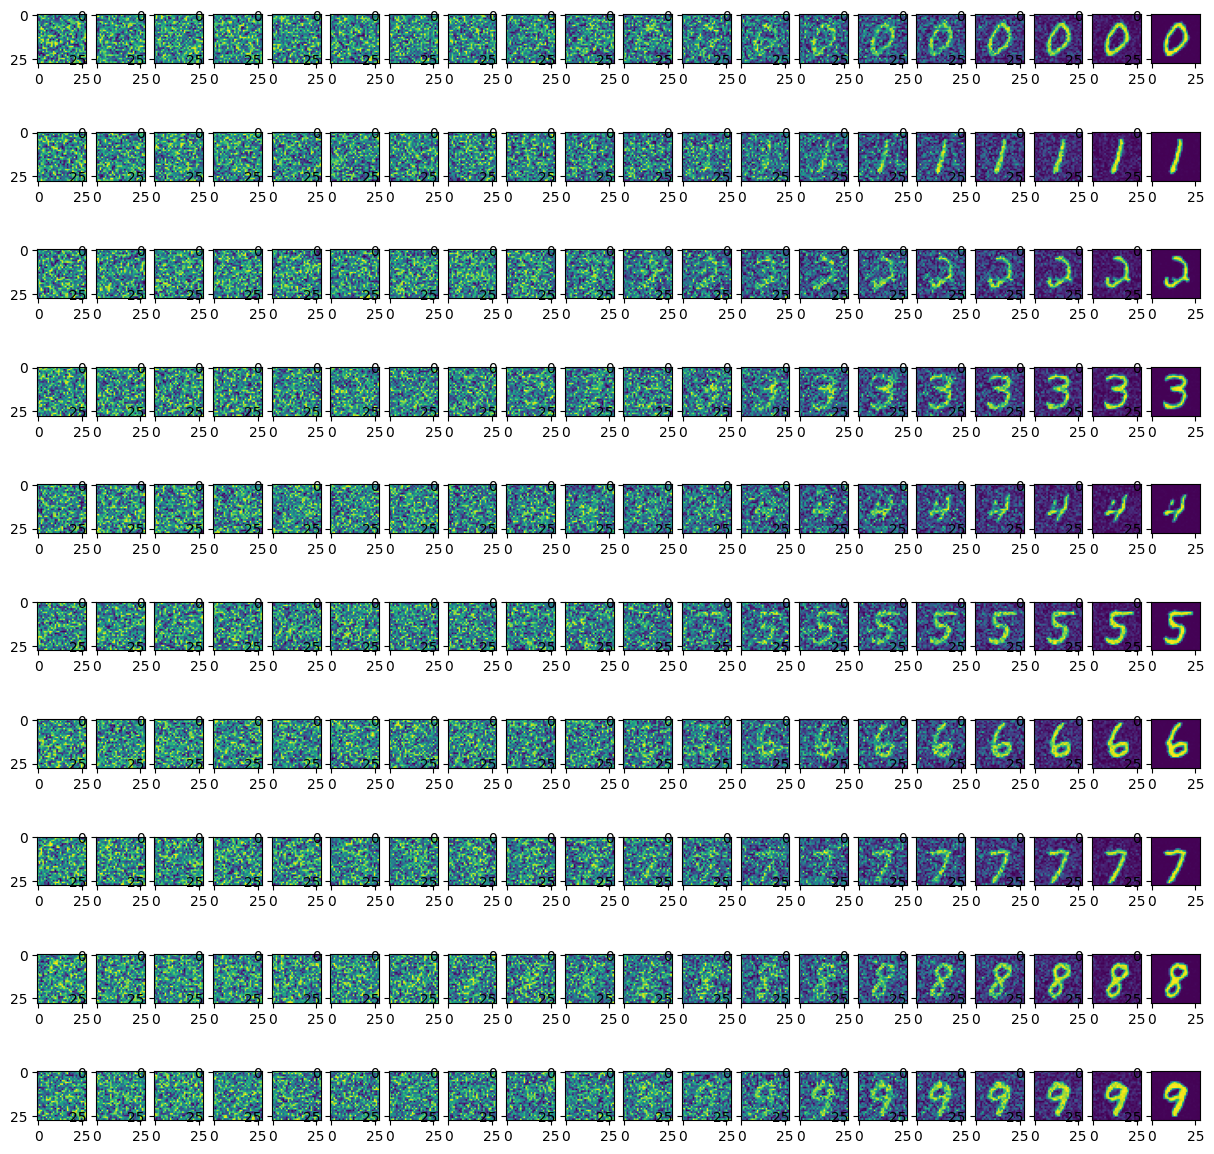

In [ ]:
import torch


import matplotlib.pyplot as plt


DEVICE='cuda' if torch.cuda.is_available() else 'cpu' # 设备

def backward_denoise(model,x,y):
    steps=[x.clone(),]

    global alphas,alphas_cumprod,variance

    x=x.to(DEVICE)
    alphas=alphas.to(DEVICE)
    alphas_cumprod=alphas_cumprod.to(DEVICE)
    variance=variance.to(DEVICE)
    y=y.to(DEVICE)

    model.eval()
    with torch.no_grad():
        for time in range(T-1,-1,-1):
            t=torch.full((x.size(0),),time).to(DEVICE)

            # 预测x_t时刻的噪音
            noise=model(x,t,y)

            # 生成t-1时刻的图像
            shape=(x.size(0),1,1,1)
            mean=1/torch.sqrt(alphas[t].view(*shape))*  \
                (
                    x-
                    (1-alphas[t].view(*shape))/torch.sqrt(1-alphas_cumprod[t].view(*shape))*noise
                )
            if time!=0:
                x=mean+ \
                    torch.randn_like(x)* \
                    torch.sqrt(variance[t].view(*shape))
            else:
                x=mean
            x=torch.clamp(x, -1.0, 1.0).detach()
            steps.append(x)
    return steps

model=DiT(img_size=28,patch_size=4,channel=1,emb_size=64,label_num=10,dit_num=3,head=4).to(DEVICE) # 模型
model.load_state_dict(torch.load('model.pth'))

# 生成噪音图
batch_size=10
x=torch.randn(size=(batch_size,1,28,28))  # (5,1,24,24)
y=torch.arange(start=0,end=10,dtype=torch.long)   #
# 逐步去噪得到原图
steps=backward_denoise(model,x,y)
# 绘制数量
num_imgs=20
# 绘制还原过程
plt.figure(figsize=(15,15))
for b in range(batch_size):
    for i in range(0,num_imgs):
        idx=int(T/num_imgs)*(i+1)
        # 像素值还原到[0,1]
        final_img=(steps[idx][b].to('cpu')+1)/2
        # tensor转回PIL图
        final_img=final_img.permute(1,2,0)
        plt.subplot(batch_size,num_imgs,b*num_imgs+i+1)
        plt.imshow(final_img)
plt.show()

### V3

In [ ]:
train_dir= '../data/mnist/train/mnist_train.csv'
test_dir= '../data/mnist/test/mnist_test.csv'
def read_mnist(file_name):
    mnist= []
    with open(file_name, encoding= 'utf-8') as f:
        mnist= f.readlines()
    rows= len(mnist)
    mnist= np.array([int(item) for sting in mnist for item in sting.split(',')]).reshape(rows, -1)
    return torch.from_numpy(mnist[:, 1:]).float()/ 255.0, torch.from_numpy(mnist[:, 0])
seed, batch_size= 1, 256
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
pics, labels= read_mnist(train_dir)
random_num= torch.rand(len(pics))
train_flag, valid_flag, test_flag= random_num< torch.tensor(0.8), (random_num>= torch.tensor(0.8))* (random_num< torch.tensor(0.9)), random_num>= torch.tensor(0.9)
train_pics, valid_pics, test_pics= pics[train_flag], pics[valid_flag], pics[test_flag]
train_labels, valid_labels, test_labels= labels[train_flag], labels[valid_flag], labels[test_flag]
train_set, valid_set, test_set= torch.utils.data.TensorDataset(train_pics, train_labels), torch.utils.data.TensorDataset(valid_pics, valid_labels), torch.utils.data.TensorDataset(test_pics, test_labels)
train_loader, valid_loader, test_loader= torch.utils.data.DataLoader(train_set, batch_size= batch_size, shuffle= True), torch.utils.data.DataLoader(valid_set, batch_size= batch_size, shuffle= True), torch.utils.data.DataLoader(test_set, batch_size= batch_size, shuffle= True)

In [16]:
def get_transforms():
    return transforms.Compose([
        transforms.ToTensor(),
    ])

def get_mnist_dataloader(train=True):
    dataset = datasets.MNIST(
        root="./data", train=train, download=True, transform=get_transforms()
    )
    dataloader = DataLoader(dataset, batch_size=Config.BATCH_SIZE, shuffle=train)
    return dataloader

In [17]:
import math
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
from typing import Optional
import matplotlib.pyplot as plt
from torch.nn import functional as F


In [18]:
class Swish(nn.Module):
    """Swish activation function."""
    def forward(self, x):
        return x * torch.sigmoid(x)

In [79]:
class DenoiseDiffusion():
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model= eps_model
        self.beta= torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha= 1- self.beta
        self.alpha_bar= torch.cumprod(self.alpha, dim= 0)
        self.n_steps= n_steps
        self.sigma= self.beta

    def gather(self, const: torch.tensor, t: torch.tensor):
        # collecting elements of consts with dim= -1 according to t
        c= const.gather(dim= -1, index= t)
        return c.reshape(-1, 1, 1, 1)

    # compute maen and var of xt according to latent
    def q_xt_x0(self, latent: torch.tensor, t: torch.tensor):
        # xt= sqrt(at)* latent+ sqrt(1- at)* eps
        # return sqrt(at)* latent, 1- at
        mean_= self.gather(self.alpha_bar, t)** 0.5* latent
        var_= 1- self.gather(self.alpha_bar, t)
        return mean_, var_

    # forward-diffusion
    def q_sample(self, latent: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor]= None):
        # compute xt according to latent
        if eps is None:
            eps= torch.randn_like(latent)
        mean_, var_= self.q_xt_x0(latent ,t)
        return mean_+ (var_** 0.5)* eps

    # sampling a pic
    def p_sample(self, xt: torch.tensor, t: torch.tensor):
        eps_hat= self.eps_model(xt, t)
        alpha_bar= self.gather(self.alpha_bar, t)
        alpha= self.gather(self.alpha, t)
        eps_coef= (1- alpha)/ (1- alpha_bar)** 0.5
        mean_= 1/ (alpha** 0.5)* (xt- eps_coef* eps_hat)
        var_= self.gather(self.sigma, t)
        eps= torch.randn(xt.shape, device= xt.device)
        return mean_+ (var_** 0.5)* eps

    # loss
    def loss(self, latent: torch.tensor, noise: Optional[torch.Tensor]= None):
        # print(f"Input to diffusion model (latent): {latent.shape}")  # Debug input shape
        batch_size= latent.shape[0]
        # (batch_size, )
        t= torch.randint(0, self.n_steps, (batch_size, ), device= latent.device, dtype= torch.long)
        # noise, (B, 4, H/ 4, W/ 4)
        if noise is None:noise= torch.randn_like(latent)
        # add noise
        xt= self.q_sample(latent, t, eps= noise)
        # print(f"Noised latent (xt): {xt.shape}")  # Debug noised latent shape
        # xt, (B, 4, H/ 4, W/ 4); t, (B, )
        eps_hat= self.eps_model(xt, t)
        # print(f"Predicted noise (eps_hat): {eps_hat.shape}")  # Debug predicted noise shape
        return F.mse_loss(noise, eps_hat)

In [80]:
class UNet_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, d_time=16, num_groups=8):
        """
        Residual block with time embedding.
        Args:
            in_channels: Input channels.
            out_channels: Output channels.
            d_time: Dimension of time embedding.
            num_groups: Number of groups for GroupNorm.
        """
        super().__init__()
        # print(f"[DEBUG] ResidualBlock initialized with in_channels={in_channels}, out_channels={out_channels}")

        # GroupNorm dynamically adjusts the number of groups
        self.gn_feat = nn.GroupNorm(min(num_groups, in_channels), in_channels)
        self.cv_feat = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.lin_time = nn.Linear(d_time, out_channels)
        self.gn_merged = nn.GroupNorm(min(num_groups, out_channels), out_channels)
        self.cv_merged = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        # Handle residual connection if channels mismatch
        self.residual_layer = (
            nn.Identity() if in_channels == out_channels
            else nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
        )

    def forward(self, feat, t):
        # print(f"[DEBUG] ResidualBlock forward: input shape={feat.shape}, time shape={t.shape}")
        residual = feat

        # First normalization and convolution
        feat = F.silu(self.gn_feat(feat))
        feat = F.silu(self.cv_feat(feat))

        # Add time embedding
        time_emb = self.lin_time(F.silu(t))
        # print(f"[DEBUG] Time embedding shape={time_emb.shape}")
        feat += time_emb[:, :, None, None]

        # Second normalization and convolution
        feat = F.silu(self.gn_merged(feat))
        feat = self.cv_merged(feat)

        # Add residual
        residual_out = self.residual_layer(residual)
        # print(f"[DEBUG] Residual shape={residual_out.shape}")
        # print(f"[DEBUG] Block output shape={feat.shape}")
        return feat + residual_out


In [81]:
class UNet_AttentionBlock(nn.Module):
    def __init__(self, n_channels: int, n_heads: int, n_dims: int = None, n_groups: int = 8):
        """
        Attention block.
        Args:
            n_channels: Number of channels.
            n_heads: Number of attention heads.
            n_dims: Dimensionality of attention embedding.
            n_groups: Groups for normalization.
        """
        super().__init__()
        if n_dims is None:
            n_dims = n_channels
        # print(f"[DEBUG] Initializing AttentionBlock: n_channels={n_channels}, n_heads={n_heads}, n_dims={n_dims}")
        self.gn = nn.GroupNorm(n_groups, n_channels)
        self.proj = nn.Linear(n_channels, n_dims * 3)  # Projection layer for Q, K, V
        self.output = nn.Linear(n_dims, n_channels)   # Output projection
        self.scale = n_dims ** -0.5
        self.n_heads = n_heads
        self.n_dims = n_dims

    def forward(self, x, t: Optional[torch.tensor] = None):
        _ = t  # Time embedding is unused in this attention block
        b, c, h, w = x.shape
        # print(f"[DEBUG] AttentionBlock forward: input x.shape={x.shape}, self.n_heads={self.n_heads}")

        # Check divisibility of channels by heads
        # if c % self.n_heads != 0:
        #     raise ValueError(
        #         f"Number of channels ({c}) must be divisible by the number of heads ({self.n_heads})."
        #     )

        # Save the original input for the residual connection
        x_original = x

        # Normalize input
        x = self.gn(x)  # GroupNorm across the channels

        # Flatten spatial dimensions
        x = x.view(b, c, h * w).permute(0, 2, 1)  # Shape: [B, H*W, C]
        # print(f"[DEBUG] After flattening and permuting: shape={x.shape}")

        # Project to Q, K, V
        proj = self.proj(x)  # Shape: [B, H*W, n_dims*3]
        # print(f"[DEBUG] After projection: shape={proj.shape}")

        # Split into Q, K, V and reshape for heads
        try:
            q, k, v = proj.reshape(b, h * w, self.n_heads, -1).chunk(3, dim=-1)
        except RuntimeError as e:
            # print(f"[DEBUG] Projection shape mismatch. Projection size: {proj.shape}")
            raise e

        # print(f"[DEBUG] q shape={q.shape}, k shape={k.shape}, v shape={v.shape}")

        # Compute attention
        att = torch.einsum("blhd,bmhd->blmh", q, k) / self.scale  # Scaled dot-product
        # print(f"[DEBUG] Attention matrix shape: {att.shape}")
        att = torch.softmax(att, dim=-2)  # Normalize across keys
        x = torch.einsum("blmh,bmhd->blhd", att, v)  # Weighted sum
        # print(f"[DEBUG] After attention computation: shape={x.shape}")

        # Reshape and output projection
        x = x.reshape(b, h * w, -1)  # Shape: [B, H*W, n_dims]
        x = self.output(x)  # Shape: [B, H*W, n_channels]
        # print(f"[DEBUG] After output projection: shape={x.shape}")

        # # Add the original input (residual connection)
        # x = x + x_original.view(b, c, h * w).permute(0, 2, 1)  # Match dimensions for addition
        # print(f"[DEBUG] After adding residual: shape={x.shape}")

        # Reshape back to [B, C, H, W]
        x = x.permute(0, 2, 1).reshape(b, c, h, w) + x_original
        # print(f"[DEBUG] After reshaping back: shape={x.shape}")
        return x


In [82]:
class SwitchSequential(nn.Sequential):
    def forward(self, x, t):
        # print(f"[DEBUG] SwitchSequential: starting forward with input shape={x.shape}")
        for layer in self:
            layer_type = type(layer).__name__
            if isinstance(layer, (UNet_AttentionBlock, UNet_ResidualBlock)):
                # print(f"[DEBUG] Passing through {layer_type}")
                x = layer(x, t)
            else:
                # print(f"[DEBUG] Passing through non-time-embedded layer {layer_type}")
                x = layer(x)
        # print(f"[DEBUG] SwitchSequential: final output shape={x.shape}")
        return x

In [83]:
class TimeEmbedding(nn.Module):
    def __init__(self, n_channels: int= 16):
        super().__init__()
        self.n_channels= n_channels
        self.lin1= nn.Linear(self.n_channels, self.n_channels)
        self.act= Swish()
        self.lin2= nn.Linear(self.n_channels, self.n_channels)
    def forward(self, t: torch.Tensor):
        half_dim= self.n_channels// 2
        emb= math.log(10000)/ (half_dim- 1)
        emb= torch.exp(torch.arange(half_dim, device= t.device)* -emb)
        emb= t[:, None]* emb[None, :]
        emb= torch.cat((emb.sin(), emb.cos()), dim= 1)
        return self.lin2(self.act(self.lin1(emb)))

In [84]:
class UNet(nn.Module):
    def __init__(self, input_channels, latent_shape):
        super().__init__()
        self.input_channels = input_channels
        self.latent_shape = latent_shape

        # Encoder: Downsampling Path
        self.encoder = nn.ModuleList([
            SwitchSequential(nn.Conv2d(input_channels, 8, kernel_size=3, padding=1)),  # Layer 1
            SwitchSequential(UNet_ResidualBlock(8, 16), nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)),  # Layer 2
            SwitchSequential(UNet_ResidualBlock(16, 32), nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1)),  # Layer 3
        ])

        # Bottleneck
        self.bottleneck = SwitchSequential(
            UNet_ResidualBlock(32, 32),
            UNet_AttentionBlock(32, n_heads=4, n_dims=8),
            UNet_ResidualBlock(32, 32)
        )

        # Decoder: Upsampling Path
        self.decoder = nn.ModuleList([
            SwitchSequential(nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), UNet_ResidualBlock(32, 32)),  # Layer 1
            SwitchSequential(nn.ConvTranspose2d(48, 16, kernel_size=4, stride=2, padding=1), UNet_ResidualBlock(16, 16)),  # Layer 2
            SwitchSequential(nn.ConvTranspose2d(24, 8, kernel_size=3, padding=1), nn.Conv2d(8, input_channels, kernel_size=3, padding=1)),  # Layer 3
        ])

        self.time_emb = TimeEmbedding(n_channels=16)  # Adjusted for bottleneck size

    def forward(self, x, t):
        # print(f"[DEBUG] UNet forward: input x shape={x.shape}, input t shape={t.shape}")
        t = self.time_emb(t)
        # print(f"[DEBUG] UNet forward: time embedding shape={t.shape}")
        skip_cont = []

        # Encoder
        for i, layer in enumerate(self.encoder):
            # print(f"[DEBUG] Passing through Encoder Layer {i+1}")
            x = layer(x, t)
            # print(f"[DEBUG] Encoder Layer {i+1} output shape={x.shape}")
            skip_cont.append(x)

        # Bottleneck
        # print(f"[DEBUG] Passing through Bottleneck")
        x = self.bottleneck(x, t)
        # print(f"[DEBUG] Bottleneck output shape={x.shape}")

        # Decoder
        for i, layer in enumerate(self.decoder):
            # print(f"[DEBUG] Passing through Decoder Layer {i+1}")
            if len(skip_cont) > 0:
                skip = skip_cont.pop()
                # print(f"[DEBUG] Skip connection shape={skip.shape}")
                x = torch.cat([x, skip], dim=1)  # Concatenate along channel dimension
                # print(f"[DEBUG] After concatenation shape={x.shape}")
            x = layer(x, t)
            # print(f"[DEBUG] Decoder Layer {i+1} output shape={x.shape}")

        # print(f"[DEBUG] UNet forward: final output shape={x.shape}")
        return x


In [29]:
class Config:
    DATASET_NAME = "MNIST"
    IMAGE_SIZE = 28
    LATENT_DIM = 64
    LATENT_SHAPE = (1, 8, 8)  # Reshaped latent dimensions for UNet
    SAVE_DIR = "/content/drive/My Drive/AI/Projects/diffusion mnist/models"
    MODEL_NAME = "Autoencoder_with_CAB.pth"
    DDPM_MODEL_NAME = "ldm_1.pth"
    BATCH_SIZE = 64
    EPOCHS = 100
    LR = 1e-3
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Encoder/Decoder Configurations
    ENCODER_CHANNELS = [1, 16, 32]         # Input -> Intermediate -> Latent
    DECODER_CHANNELS = [32, 16, 1]         # Latent -> Intermediate -> Output
    NUM_CABS_ENCODER = [1, 0]              # Number of CABs in each encoder layer
    NUM_CABS_DECODER = [1, 0]              # Number of CABs in each decoder layer
    REDUCTION_FACTOR = 8                  # Channel attention reduction factor
    DEBUG = False                          # Enable debugging prints

In [ ]:
########

In [59]:
autoencoder = Autoencoder(latent_dim=Config.LATENT_DIM).to(Config.DEVICE)
load_path = os.path.join(Config.SAVE_DIR, Config.MODEL_NAME)
autoencoder.load_state_dict(torch.load(load_path))
autoencoder.eval()  # Ensure the Autoencoder is in evaluation mode

<ipython-input-59-5309b25c016e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(load_path))


Autoencoder(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): CAB(
        (body): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (ca): CALayer(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (conv_du): Sequential(
            (0): Conv2d(16, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): ReLU(inplace=True)
            (2): Conv2d(2, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (3): Sigmoid()
          )
        )
      )
      (2): ReLU()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): ReLU()
    )
    (flatten): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=1568

In [85]:
patience =  20
device = Config.DEVICE
u_net= UNet(Config.LATENT_SHAPE[0], Config.LATENT_SHAPE).to(device)
dm= DenoiseDiffusion(u_net, 1000, device= device)
opt_dm= torch.optim.Adam(u_net.parameters(), lr= Config.LR)
diff_path = os.path.join(Config.SAVE_DIR, Config.DDPM_MODEL_NAME)

In [ ]:
########

In [27]:
# Using your custom data loader function
train_loader = get_mnist_dataloader(train=True)
test_loader = get_mnist_dataloader(train=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.55MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.31MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [86]:
best_score, score, early_stop_time = 1e10, 0, 0

for epoch in range(Config.EPOCHS):
    loss_record = []
    for step, (pics, labels) in enumerate(train_loader):
        # Move data to the device
        pics = pics.view(-1, 1, Config.IMAGE_SIZE, Config.IMAGE_SIZE).to(device)
        # print(f"Input pics shape: {pics.shape}")  # Check shape after loading
        # Encode using the Autoencoder
        latent = autoencoder.encode(pics)
        # print(f"Latent shape (encoder output): {latent.shape}")  # Check latent shape
        # Compute diffusion model loss
        # Reshape latent to [B, C, H, W]
        latent = latent.view(-1, *Config.LATENT_SHAPE)  # Shape: [B, 1, 8, 8]
        # print(f"Reshaped latent for diffusion: {latent.shape}")
        loss = dm.loss(latent)
        opt_dm.zero_grad()
        loss_record.append(loss.item())
        loss.backward()
        opt_dm.step()

    # # Print training loss
    # avg_train_loss = torch.tensor(loss_record).mean()
    # print(f"Training Epoch: {epoch + 1}, Mean Loss: {avg_train_loss:.4f}")
    # break  # Exit after one epoch for debugging purposes

    # Print training loss
    avg_train_loss = torch.tensor(loss_record).mean()
    print(f"Training Epoch: {epoch + 1}, Mean Loss: {avg_train_loss:.4f}")

    # Validation phase
    loss_record = []
    with torch.no_grad():
        for step, (pics, labels) in enumerate(test_loader):
            pics = pics.view(-1, 1, Config.IMAGE_SIZE, Config.IMAGE_SIZE).to(device)
            latent = autoencoder.encode(pics)
            loss = dm.loss(latent)
            loss_record.append(loss.item())

    mean_loss = torch.tensor(loss_record).mean()

    # Early stopping logic
    if mean_loss < best_score:
        early_stop_time = 0
        best_score = mean_loss
        torch.save(u_net.state_dict(), diff_path)  # Save only model state_dict
    else:
        early_stop_time += 1

    if early_stop_time > patience:
        print("Early stopping triggered.")
        break

    print(f"Validation Mean Loss: {mean_loss:.4f}, Early Stop Counter: {early_stop_time}/{patience}")


Training Epoch: 1, Mean Loss: 0.3878


<ipython-input-79-18730ac61f99>:57: UserWarning: Using a target size (torch.Size([64, 1, 64, 64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(noise, eps_hat)
<ipython-input-79-18730ac61f99>:57: UserWarning: Using a target size (torch.Size([16, 1, 16, 64])) that is different to the input size (torch.Size([16, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(noise, eps_hat)


Validation Mean Loss: 2.1858, Early Stop Counter: 0/20
Training Epoch: 2, Mean Loss: 0.3122
Validation Mean Loss: 2.3979, Early Stop Counter: 1/20
Training Epoch: 3, Mean Loss: 0.2985
Validation Mean Loss: 2.4046, Early Stop Counter: 2/20
Training Epoch: 4, Mean Loss: 0.2864
Validation Mean Loss: 2.5175, Early Stop Counter: 3/20
Training Epoch: 5, Mean Loss: 0.2818
Validation Mean Loss: 2.7534, Early Stop Counter: 4/20
Training Epoch: 6, Mean Loss: 0.2787
Validation Mean Loss: 2.6267, Early Stop Counter: 5/20
Training Epoch: 7, Mean Loss: 0.2707
Validation Mean Loss: 2.6172, Early Stop Counter: 6/20
Training Epoch: 8, Mean Loss: 0.2694
Validation Mean Loss: 2.7103, Early Stop Counter: 7/20
Training Epoch: 9, Mean Loss: 0.2693
Validation Mean Loss: 2.7813, Early Stop Counter: 8/20
Training Epoch: 10, Mean Loss: 0.2650
Validation Mean Loss: 2.8371, Early Stop Counter: 9/20
Training Epoch: 11, Mean Loss: 0.2642
Validation Mean Loss: 2.7812, Early Stop Counter: 10/20
Training Epoch: 12, Me

In [95]:
def show_sample2d(images, texts):
    num_rows = len(images)
    num_cols = len(images[0]) if images else 0
    _, figs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    for i in range(num_rows):
        for j in range(num_cols):
            f, img, text= figs[i][j], images[i][j], texts[i][j]
            img = img.view(28, 28)
            f.imshow(img, cmap='gray')
            f.axis('off')
            f.text(0.5, 0.05, text, ha='center', va='center', fontsize=12,
                   color='white', backgroundcolor='black', bbox=dict(facecolor='black', edgecolor='none', boxstyle='round'))
    # plt.subplots_adjust(wspace=0.24, hspace=-0.88)
    plt.show()

In [ ]:
autoencoder = Autoencoder(latent_dim=Config.LATENT_DIM).to(Config.DEVICE)
load_path = os.path.join(Config.SAVE_DIR, Config.MODEL_NAME)
autoencoder.load_state_dict(torch.load(load_path))
autoencoder.eval()  # Ensure the Autoencoder is in evaluation mode

<ipython-input-59-5309b25c016e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(load_path))


Autoencoder(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): CAB(
        (body): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (ca): CALayer(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (conv_du): Sequential(
            (0): Conv2d(16, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): ReLU(inplace=True)
            (2): Conv2d(2, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (3): Sigmoid()
          )
        )
      )
      (2): ReLU()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): ReLU()
    )
    (flatten): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=1568

In [ ]:
patience =  20
device = Config.DEVICE
u_net= UNet(Config.LATENT_SHAPE[0], Config.LATENT_SHAPE).to(device)
dm= DenoiseDiffusion(u_net, 1000, device= device)
opt_dm= torch.optim.Adam(u_net.parameters(), lr= Config.LR)
diff_path = os.path.join(Config.SAVE_DIR, Config.DDPM_MODEL_NAME)

In [93]:
from tqdm import tqdm
test_pic_num= 10
images, texts= [], []
for i in range(test_pic_num):
    images_, texts_= [], []
    print(f'sample {i+ 1} image, denoising...')
    xt= torch.randn((1, 1, 8, 8), device= device)
    for t in tqdm(reversed(range(1000))):
        xt_1= dm.p_sample(xt, torch.tensor([t]).to(device))
        xt= xt_1
        if (t+ 1)% 100== 1:
            # Reshape xt to match decoder input
            xt_reshaped = xt.view(1, -1)  # Flatten to [batch_size, LATENT_DIM]
            denoising_pic = autoencoder.decoder(xt_reshaped)
            images_.append(denoising_pic.view(1, 28, 28).to("cpu").detach())
            texts_.append(t + 1)
    images.append(images_)
    texts.append(texts_)

sample 1 image, denoising...


1000it [00:06, 160.85it/s]


sample 2 image, denoising...


1000it [00:06, 145.50it/s]


sample 3 image, denoising...


1000it [00:06, 164.96it/s]


sample 4 image, denoising...


1000it [00:06, 144.08it/s]


sample 5 image, denoising...


1000it [00:06, 162.90it/s]


sample 6 image, denoising...


1000it [00:07, 139.31it/s]


sample 7 image, denoising...


1000it [00:05, 168.86it/s]


sample 8 image, denoising...


1000it [00:07, 141.56it/s]


sample 9 image, denoising...


1000it [00:05, 167.95it/s]


sample 10 image, denoising...


1000it [00:07, 137.20it/s]


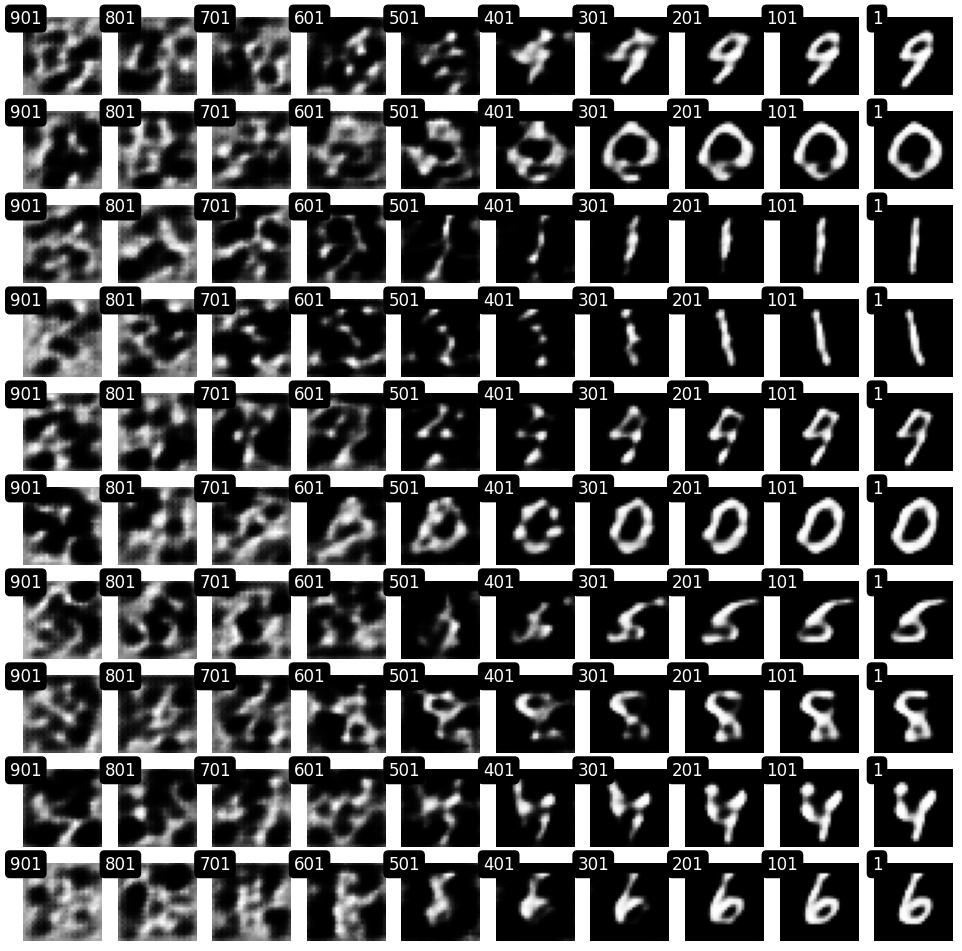

In [96]:
show_sample2d(images, texts)
